In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Shin Dong-hyeok: tlsehdgur0@kaist.ac.kr; Bae Hee-sun: cat2507@kaist.ac.kr
'''


import time
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras 
from sklearn.manifold import TSNE

In [6]:
class CVariationalAutoEncoder:

    network_architecture = [] # network_architecture : 인공신경망의 구조를 저장
    all_weights = {}
    transfer_fct = 0

    x = [] # x : VAE의 Input
    x_reconstr_mean = [] # x_reconstr_mean : VAE의 Output
    y = [] # y : Input의 label
    z = [] # z : VAE의 latent variable
    z_mean = [] # z_mean : VAE의 latent variable의 mean
    z_log_sigma_sq = [] # z_log_sigma_sq : VAE의 latent variable의 log sigma sq
    
    x_concat = [] # input과 label의 concatenation
    z_concat = [] # latent와 label의 concatenation

    sess = 0
    cost = 0
    optimizer = 0
    

    def __init__(self,network_architecture,transfer_fct=tf.nn.sigmoid):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct # self.transfer_fct : activation function을 저장, 기본값은 sigmoid function으롤 설정


    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):

        self.all_weights['weights_recog'] = { 'h1' : tf.Variable(self.xavier_init(n_input+10,n_hidden_recog_1),dtype=tf.double, trainable=True), \
                                         'h2' : tf.Variable(self.xavier_init(n_hidden_recog_1,n_hidden_recog_2),dtype=tf.double, trainable=True), \
                                         'out_mean': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z),dtype=tf.double, trainable=True), \
                                         'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z),dtype=tf.double, trainable=True)}

        self.all_weights['biases_recog'] = { 'b1' : tf.Variable(tf.zeros([n_hidden_recog_1],dtype=tf.double), trainable=True), \
                                        'b2' : tf.Variable(tf.zeros([n_hidden_recog_2],dtype=tf.double), trainable=True), \
                                        'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.double), trainable=True), \
                                        'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.double), trainable=True)}        
        
        self.all_weights['weights_gener'] = {'h1': tf.Variable(self.xavier_init(n_z+10, n_hidden_gener_1),dtype=tf.double, trainable=True), \
                                        'h2': tf.Variable(self.xavier_init(n_hidden_gener_1, n_hidden_gener_2),dtype=tf.double, trainable=True), \
                                        'out_mean': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input),dtype=tf.double, trainable=True), \
                                        'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input),dtype=tf.double, trainable=True)}

        self.all_weights['biases_gener'] = {'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.double), trainable=True), \
                                       'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.double), trainable=True), \
                                       'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.double), trainable=True), \
                                       'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.double), trainable=True)}
        return self.all_weights

    def _recognition_network(self,weights,biases,x_concat):
        # VAE의 recognition network의 역할을 수행하는 method
        # Input : (recognition network의) weights, biases
        # Output: (z_mean, z_log_sigma_sq)
        layer_1 = self.transfer_fct(tf.add(tf.matmul(x_concat, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*(X:Y))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        z_mean = tf.add(tf.matmul(layer_2,weights['out_mean']),biases['out_mean']) # z_mean = b_{out_mean} + W_{out mean}*L2
        z_log_sigma_sq = tf.add(tf.matmul(layer_2,weights['out_log_sigma']),biases['out_log_sigma'])
        # z_log_sigma_sq = b_{log_sigma_sq} + W_{log_sigma_sq}*L2
        return (z_mean,z_log_sigma_sq)

    def _generator_network(self,weights,biases,z_concat):
        # VAE의 generator network의 역할을 수행하는 method
        # Input : (generator network의) weights, biases
        # Output : x_reconstr_mean
        layer_1 = self.transfer_fct(tf.add(tf.matmul(z_concat, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*(Z:Y))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        # x_reconstr_mean = b_{out_mean}+W_{out_mean}*L2

        return x_reconstr_mean
    
    def _reparameterization(self, z_mean, z_log_sigma_sq):
        # Z mean과 Z sigma를 이용해 Z를 reparameterize하는 method
        # Input : z_mean, z_log_sigma_sq
        # Output : z, z_concat       
        
        n_z = self.network_architecture["n_z"]
        n_batch = len(z_log_sigma_sq)

        # Reparameteriation trick
        eps = tf.random.normal((n_batch,n_z),0,1,dtype=tf.double)


        z = tf.add(z_mean,tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)),eps))
        z_concat = tf.concat([z, self.y], 1) # latent + label


        return z ,z_concat
    
    def get_weights(self):
        # Training될 weight를 모두 반환하는 method
        
        weights = []
        weights.append(self.all_weights["weights_recog"]['h1'])
        weights.append(self.all_weights["biases_recog"]['b1'])
        weights.append(self.all_weights["weights_recog"]['h2'])
        weights.append(self.all_weights["biases_recog"]['b2'])
        weights.append(self.all_weights["weights_recog"]['out_mean'])
        weights.append(self.all_weights["biases_recog"]['out_mean'])        
        weights.append(self.all_weights["weights_recog"]['out_log_sigma'])
        weights.append(self.all_weights["biases_recog"]['out_log_sigma'])
        weights.append(self.all_weights["weights_gener"]['h1'])
        weights.append(self.all_weights["biases_gener"]['b1'])
        weights.append(self.all_weights["weights_gener"]['h2'])
        weights.append(self.all_weights["biases_gener"]['b2'])
        weights.append(self.all_weights["weights_gener"]['out_mean'])
        weights.append(self.all_weights["biases_gener"]['out_mean'])     
        
        return weights
    
    def model(self, x, y):
        # CVAE의 encoder/decoder network를 거쳐 cost를 반환하는 메소드
        # Input : x, y (Input)
        # Output : Cost
        self.x = x
        self.y = y
        self.x_concat = tf.concat([x, y], -1) # input + label
        
        #recognition network
        weights, biases = self.all_weights["weights_recog"], self.all_weights["biases_recog"] 
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(weights,biases,self.x_concat)
        
        #reparameterization
        self.z, self.z_concat = self._reparameterization(self.z_mean, self.z_log_sigma_sq)

        #generator network
        weights, biases = self.all_weights["weights_gener"], self.all_weights["biases_gener"]       
        self.x_reconstr_mean = self._generator_network(weights,biases,self.z_concat)
        

        reconstr_loss = -tf.reduce_sum(x*tf.math.log(1e-10+self.x_reconstr_mean)+(1-x)*tf.math.log(1e-10+1-self.x_reconstr_mean),1)
        latent_loss = -0.5*tf.reduce_sum(1+self.z_log_sigma_sq-tf.square(self.z_mean)-tf.exp(self.z_log_sigma_sq),1)

        self.cost = tf.reduce_mean(reconstr_loss+latent_loss)
        return self.cost    
    
    def _create_loss_optimizer(self,learning_rate):
        # VAE의 total cost를 계산하고, 이를 minimize하는 optimizer 설정하는 메소드
        # Input : learning_rate
        # Output : None        
        self.learning_rate = learning_rate
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    def train_step( self, input_x, input_y):

        with tf.GradientTape() as tape:
            current_loss = self.model(tf.Variable(input_x, dtype='double'),tf.Variable(input_y,dtype='double'))
            weights = self.get_weights() 

        grads = tape.gradient( current_loss , weights )

        self.optimizer.apply_gradients( zip( grads , weights ) )

        return current_loss

        
    def transform(self,input_x,input_y):
        # CVAE의 encoder network를 통하여 latent variable z_mean과 y의 concatenation을 return하는 메소드
        # Input : x, y
        # Output : z_concat 
        
        x = tf.Variable(input_x, dtype='double')
        y = tf.Variable(input_y,dtype='double')
        x_concat = tf.concat([x, y], 1) # input + label

        z_mean, z_log_sigma_sq = self._recognition_network(self.all_weights['weights_recog'],self.all_weights["biases_recog"],x_concat)
        
        z_concat =  tf.concat([z_mean, y], 1)
        
        return z_concat
    
    def generate(self,z_concat):
        # CVAE의 decoder network를 통하여 reconstruct된 mean을 return하는 메소드
        # Input : z_concat
        # Output : reconstr_mean       
        reconstr_mean = self._generator_network(self.all_weights["weights_gener"],self.all_weights["biases_gener"],z_concat)
        return reconstr_mean
    
    def reconstruct(self,x,y):
        # CVAE를 통하여 X를 reconstruct한 후, 이 mean을 return하는 메소드
        # Input : x,y
        # Output : (CVAE를 통한) x_reconstr_mean    
        
        return self.generate(self.transform(x,y))


    def xavier_init(self,fan_in, fan_out, constant=1): 
        # Xavier initialization method
        # Input : fan_in(들어오는 layer의 크기), fan_out(나가는 layer의 크기)
        # Output : 각 원소가 random uniform value인 (fan_in, fan_out) 형태의 tensor 
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))

        return tf.random.uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.double)


    def train(self,trainX,trainY,batch_size=100,training_epochs=500,learning_rate=0.0005):
        # CVAE를 생성하고, trainX/Y를 training하는 메소드
        # Input : trainX, trainY, batch_size, training_epochs, learning_rate
        # Output : None
        
        total_costs = np.zeros(training_epochs)
        
        self.all_weights = self._initialize_weights(**self.network_architecture) #weight 초기화

        self._create_loss_optimizer(learning_rate) # VAE의 loss function과 optimizer 생성

        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.gpu.set_per_process_memory_fraction(0.333)
            
        startTime = time.time()
        for epoch in range(training_epochs): # training_epochs만큼 반복 실행
            avg_cost = 0. # training set의 average cost 
            total_batch = int(len(trainX)/batch_size) # total batch : 전체 batch의 갯수

            for i in range(total_batch): # total_batch만큼 반복 실행
                batch = []
                batch_label = []
                for j in range(batch_size):
                    batch.append(trainX[i*batch_size+j]) # training X를 여러개 batch로 나누는 과정
                    batch_label.append(trainY[i*batch_size+j]) # training X에 대응하는 training Label 또한 여러개 batch로 나눈다
#                 cost = self.partial_fit(batch,batch_label) # i번째 batch의 cost 계산
                cost = self.train_step(batch,batch_label)
                avg_cost += cost / n_samples*batch_size
            
            total_costs[epoch] = avg_cost
            
            print("Epoch : ",'%04d'%(epoch+1)," Cost = ","{:.9f}".format(avg_cost))
            print("Elapsed Time : " + str((time.time() - startTime))) # 각 epcoh의 실행 소요 시간 
        
        # epcch에 따른 cost 그래프 출력 과정
        plt.plot(total_costs)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()
        return

    def plotReconstruct(self,testData,testAmount,strFileName):
        # testData를 CVAE를 통해 label을 붙여reconstruct한 후, Input test image와 reconstructed output image를 plot하는 메소드  
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
            
        # test data에 붙일 label 생성
        label = []
        for i in range(10):
            label.append([])
            for j in range(10):
                label[i].append(0)
            for k in range(10):
                if k == i:
                    label[i][k] = 1
            label[i] = np.array(label[i]) # 0~9 one hot vector : label[i] means i

        # x_reconstruct : testData와 testLabel을 이용하여 reconstruct한 데이터
        x_reconstruct = []
        for n in range(10):
            x_reconstruct.append([])
        for i in range(10):
            Labellist = []
            for data in range(testAmount):
                Labellist.append(label[i])
            Labellist = np.array(Labellist)
            x_reconstruct[i] = self.reconstruct(testData, Labellist) # reconstruct(testData, label[i])
            
        plt.figure(figsize=(35, 50))
        samplenum = 20
        for d_num in range(samplenum): # testData의 처음 samplenum개를 plot
            
            # Original Input image plot
            plt.subplot(samplenum, 11, 11 * d_num + 1) #원래 그림
            plt.imshow(testData[d_num].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
            plt.title("Test Input")
            plt.colorbar()
            
            # Reconstructed Output image plot
            for l_num in range(10):
                plt.subplot(samplenum, 11, 11 * d_num + l_num + 2) # l num을 label로 reconstruction한 그림
                
                plt.imshow(tf.reshape(x_reconstruct[l_num][d_num], [28, 28]), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
                plt.title("Reconstruction"+str(l_num))
                plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotScatter2D(self,testDataFeature,testDataClass,strFileName):
        # test data와 label을 2-D latent Space위에 Scatter plot으로 표현하는 메소드
        
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])

        z_mu = self.transform(testDataFeature,testDataClass)
        plt.figure(figsize=(8, 6))
        plt.scatter(z_mu[:,0],z_mu[:,1],c=np.argmax(testDataClass,1))
        plt.colorbar()
        plt.grid()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

In [4]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(60000, 784).astype('double')
x_test = x_test.reshape(10000, 784).astype('double')

y_train = tf.one_hot(y_train, 10, dtype ='double')
y_test = tf.one_hot(y_test, 10, dtype='double')

n_samples =len(x_train)

## CVAE with 10 dimension of latent space

Epoch :  0001  Cost =  195.530629935
Elapsed Time : 40.052929401397705
Epoch :  0002  Cost =  155.024459074
Elapsed Time : 78.83420062065125
Epoch :  0003  Cost =  137.359710361
Elapsed Time : 117.83497786521912
Epoch :  0004  Cost =  128.155494792
Elapsed Time : 157.83599209785461
Epoch :  0005  Cost =  122.631610553
Elapsed Time : 197.07306337356567
Epoch :  0006  Cost =  118.449614624
Elapsed Time : 237.96637892723083
Epoch :  0007  Cost =  114.954535147
Elapsed Time : 278.33839678764343
Epoch :  0008  Cost =  112.587860435
Elapsed Time : 318.51693296432495
Epoch :  0009  Cost =  110.791610073
Elapsed Time : 356.930508852005
Epoch :  0010  Cost =  109.460399898
Elapsed Time : 395.56419920921326
Epoch :  0011  Cost =  108.368601211
Elapsed Time : 434.16594648361206
Epoch :  0012  Cost =  107.410902196
Elapsed Time : 472.6671314239502
Epoch :  0013  Cost =  106.726073553
Elapsed Time : 511.7287971973419
Epoch :  0014  Cost =  106.037145956
Elapsed Time : 552.3831675052643
Epoch :  001

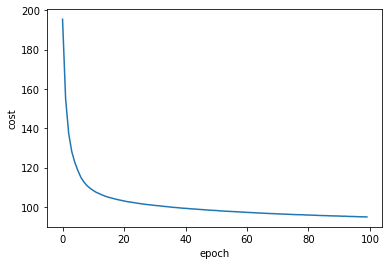

In [7]:
# z dimension이 10인 CVAE의 구조를 저장
# 784 500 500 10 500 500 784
network_architecture = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=10)

cvae = CVariationalAutoEncoder(network_architecture) # z dimension이 10인 VAE instance 생성
cvae.train(x_train,y_train,batch_size=100,training_epochs=100,learning_rate=0.001) # VAE training

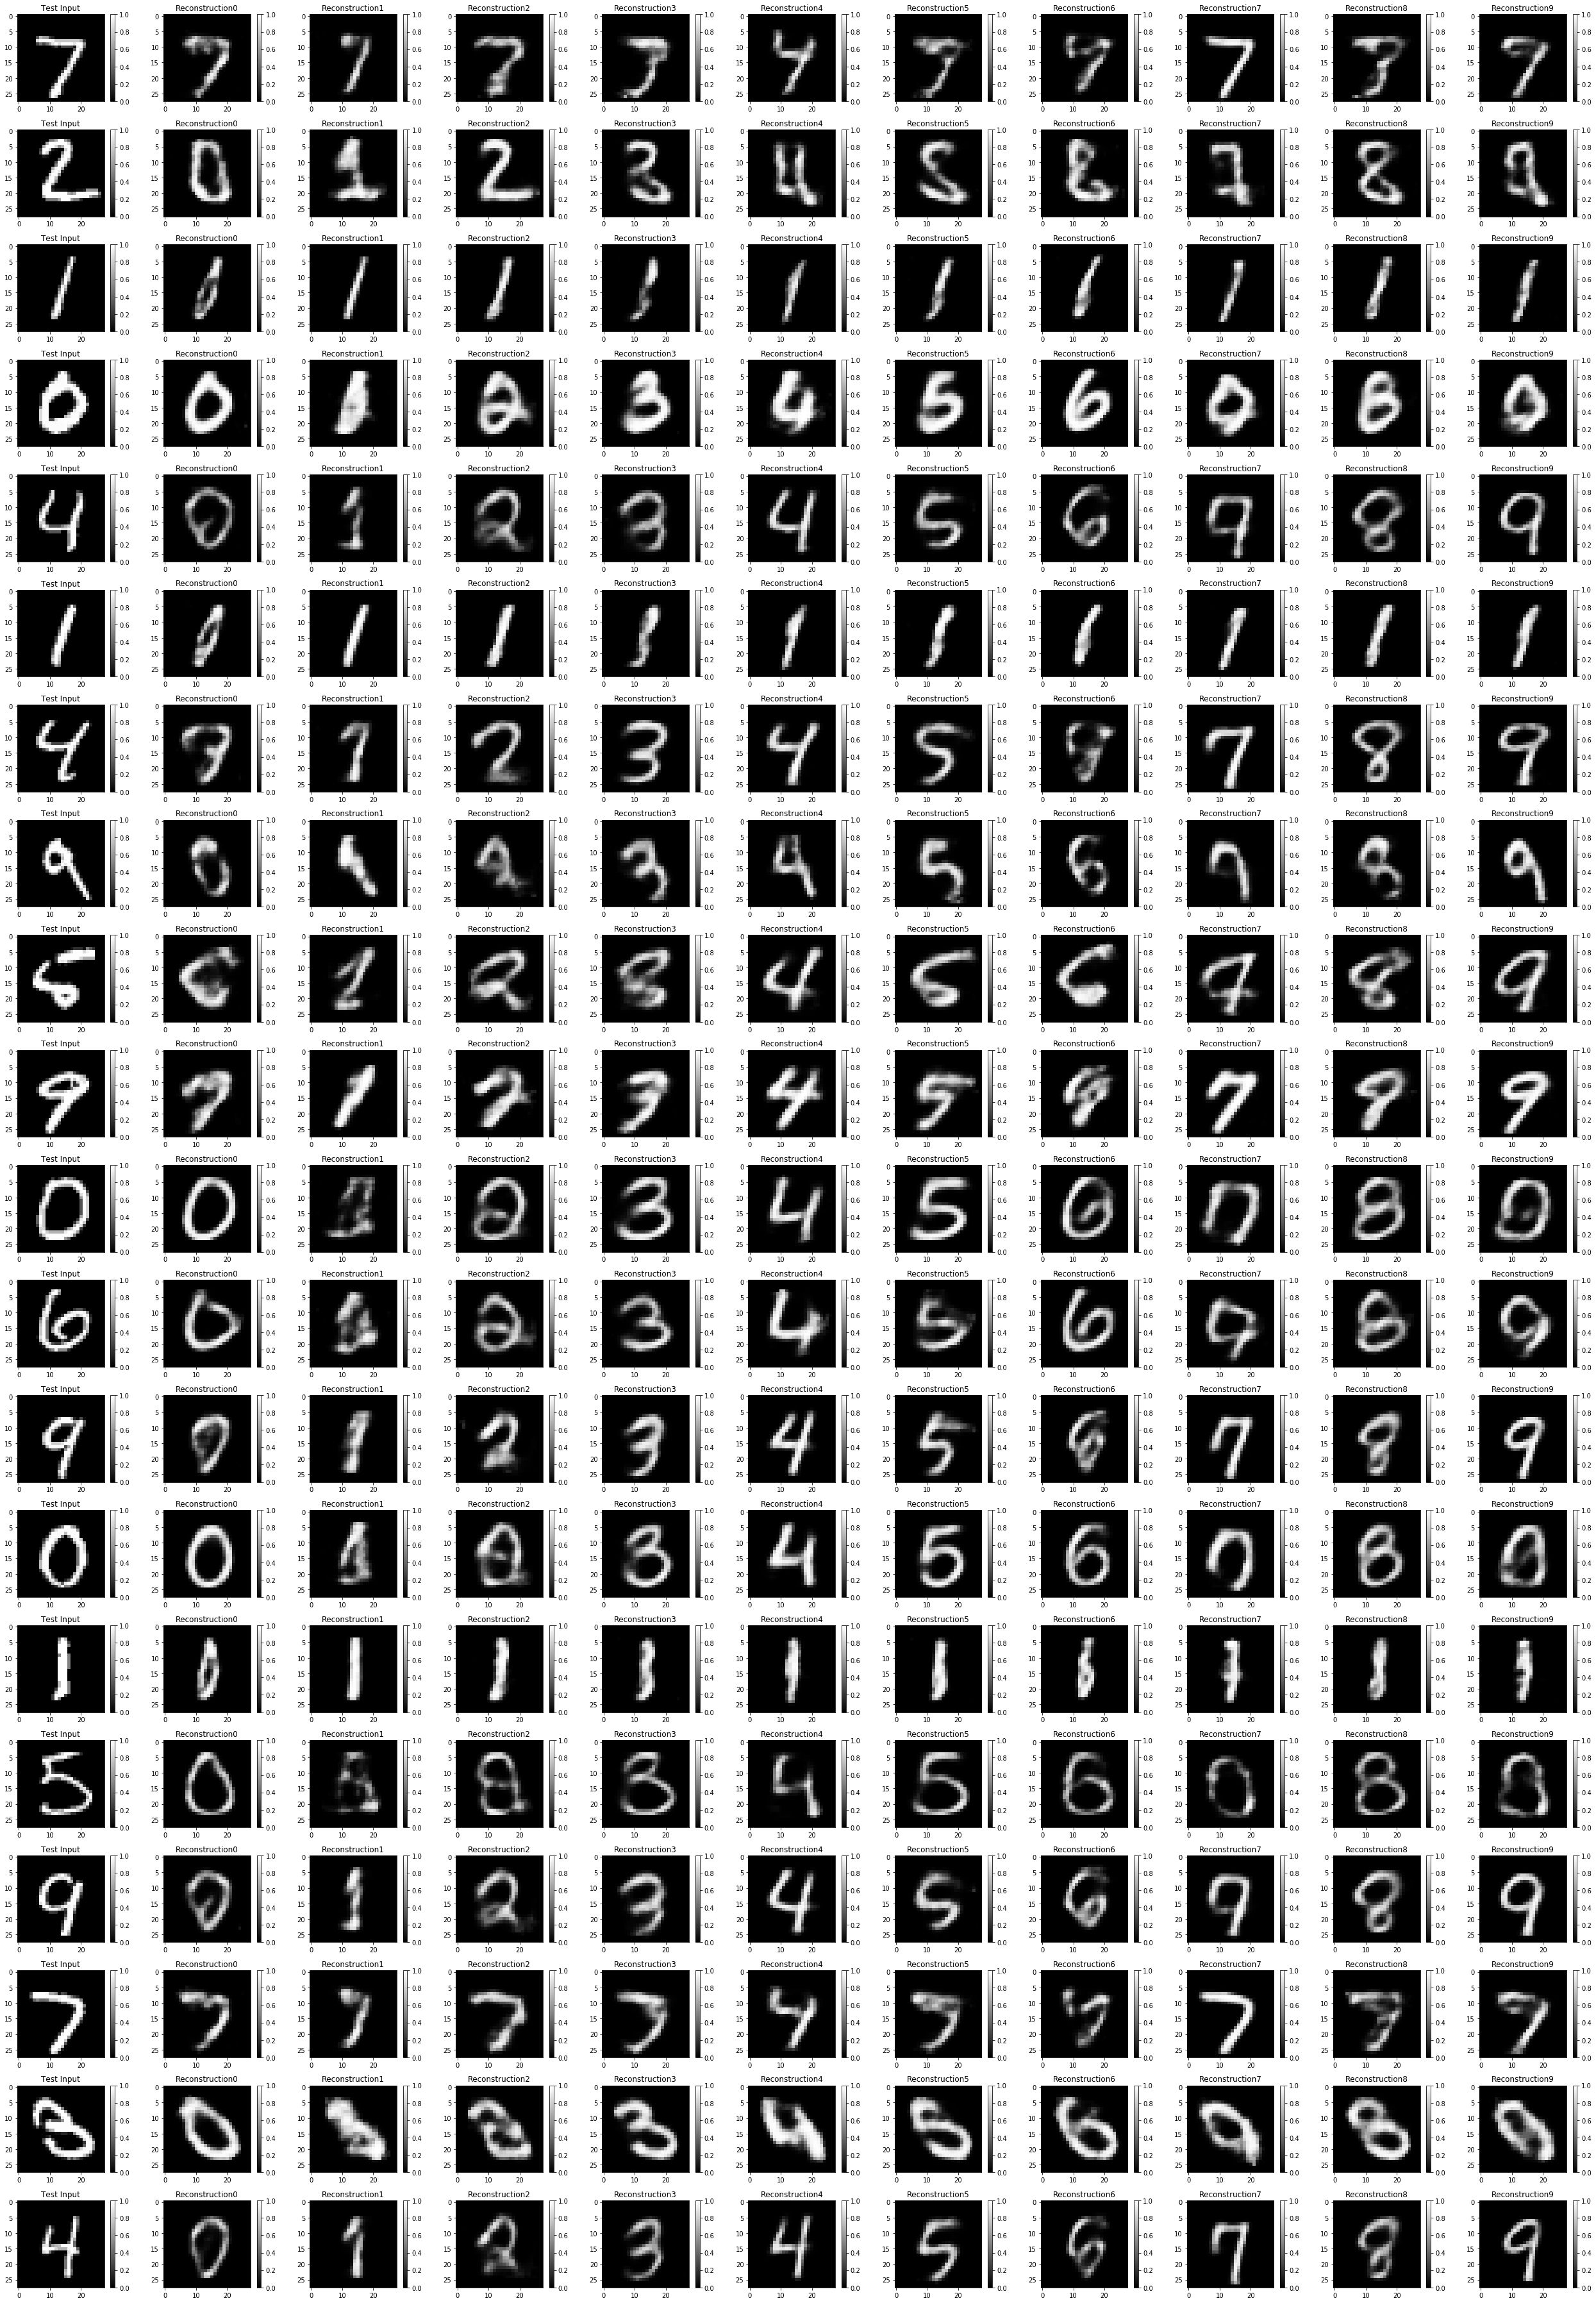

In [119]:
cvae.plotReconstruct(x_test,10000,'./log/VAE-Reconstruct.png') # testX를 이용하여 reconstruct한 후 이를 plot

## 결과해석부1

위의 출력 결과는 latent space가 10차원인 CVAE로 학습한 결과입니다.

출력문은 각 epoch의 average cost와 실행 소요 시간을 나타낸 것이며, 그래프는 x축은 epoch, y축은 cost로 epoch에 따른 cost의 변화를 표현한 것입니다.  
또한 출력된 10개의 image 중 가장 좌측의 column은 Original Input test image이고, 우측은 좌측의 데이터를 0부터 9까지 각각 다른 label을 붙여 reconstruct한 Output image입니다.

위의 출력 결과를 통해 Training을 진행할수록(Epoch가 증가할수록), total cost가 꾸준히 감소함을 확인할 수 있습니다.
Original input data image에 따라 맞는 label을 붙인 output data가 잘 reconstruct되었으므로, 이는 구현한 CVAE가 유의미하게 learning되었음을 알 수 있습니다.

같은 data에 다른 label을 붙일 경우, label이 output의 reconstruct에 큰 영향을 주고 있으므로 condition이 의미가 있음을 알 수 있습니다.

## CVAE with 2 dimension of latent space

Epoch :  0001  Cost =  233.191420285
Elapsed Time : 57.79183912277222
Epoch :  0002  Cost =  206.541391671
Elapsed Time : 113.86671900749207
Epoch :  0003  Cost =  206.206054720
Elapsed Time : 177.57788181304932
Epoch :  0004  Cost =  202.789586336
Elapsed Time : 239.2444770336151
Epoch :  0005  Cost =  189.856736669
Elapsed Time : 296.1778290271759
Epoch :  0006  Cost =  179.802758356
Elapsed Time : 351.128839969635
Epoch :  0007  Cost =  173.890392311
Elapsed Time : 409.9100868701935
Epoch :  0008  Cost =  170.014878961
Elapsed Time : 468.1426680088043
Epoch :  0009  Cost =  166.799136966
Elapsed Time : 524.0892548561096
Epoch :  0010  Cost =  163.777199003
Elapsed Time : 580.5632309913635
Epoch :  0011  Cost =  160.675366713
Elapsed Time : 637.098494052887
Epoch :  0012  Cost =  157.668414607
Elapsed Time : 691.5021419525146
Epoch :  0013  Cost =  154.753135522
Elapsed Time : 749.0828900337219
Epoch :  0014  Cost =  152.214668155
Elapsed Time : 805.7583649158478
Epoch :  0015  Cost 

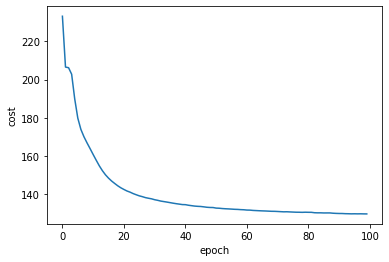

In [120]:
# z dimentsion이 2인 CVAE의 구조를 저장
# 784 500 500 2 500 500 784
network_architecture2D = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=2)


cvae2D = CVariationalAutoEncoder(network_architecture2D) # latent variable이 2차원이므로 평면에 점을 찍어 나타낼 수 있다.
cvae2D.train(x_train,y_train,batch_size=1000,training_epochs=100,learning_rate=0.001)

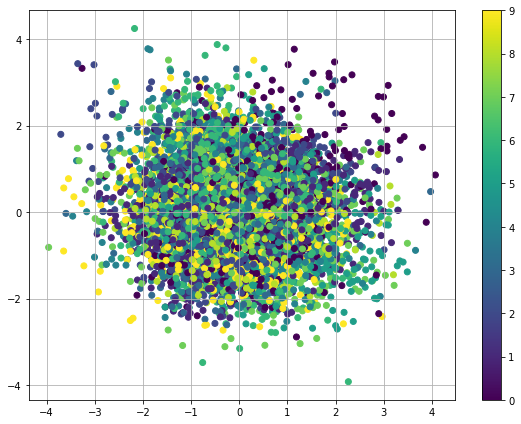

In [121]:
cvae2D.plotScatter2D(x_test,y_test,'./log/VAE-2D-Scatter.png')

## Comparing with t-SNE graph

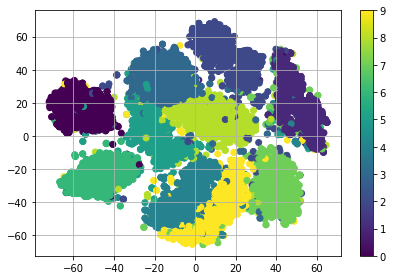

In [122]:
model = TSNE(learning_rate=100) #t-SNE
transformed = model.fit_transform(x_test) # t-SNE의 결과를 반환해준다

df = pd.DataFrame()
df['x'], df['y'] = transformed[:,0], transformed[:,1]

cs = [] # one-hot vector로 들어가있는 label을 숫자로 표현해서 색으로 사용할 것이다.
for i in range(len(y_test)):
    for j in range(10):
        if y_test[i][j] == 1:
            cs.append([j])
df['c'] = np.array(cs)

plt.scatter(df['x'], df['y'], c=df['c'])
plt.colorbar()
plt.grid()

plt.tight_layout()
plt.show()

## 결과 해석부2

위의 출력 결과는 latent space가 2차원인 CVAE로 학습한 결과입니다.

출력문은 각 epoch의 average cost와 실행 소요 시간을 나타낸 것이며, 그래프는 x축은 epoch, y축은 cost로 그래프를 표현한 것입니다.  
그 다음 그래프는 색깔로 label(= digit)을 표현한 test data가 2차원 latent space의 scatter plot입니다.  

latent space가 10차원인 경우와 유사하게 Training을 진행할수록 cost가 감소하는 것을 확인할 수 있습니다.  

Scatter plot에서는 서로 다른 여러 색의 점이 섞여있는 것으로 보아, VAE와는 다르게 input으로 다른 data를 넣어도 latent value에 큰 차이가 없다는 것을 알 수 있습니다. 이것은 CVAE에서 condition이 얼마나 큰 영향을 가지는지 보여준다고 할 수 있습니다.

아래 그래프는 t-SNE 그래프입니다. 위의 latent variable로 구성된 그래프와는 달리, label에 의해 잘 분류된 점들을 보여줍니다.